In [1]:
%cd ..

d:\Projects\vislang\vis_lang


In [3]:
from cifar10_emb import Cifar10Emb
import torch
import matplotlib.pyplot as plt

In [4]:
variant = Cifar10Emb(root_path='.')

variant.dataloader_args['batch_size'] = 32

variant.init_datasets()
variant.init_dataloaders()
variant.set_up_model_architecture(300)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
variant.init_word_lookup()

In [16]:
state = torch.load('./vis_lang/cifar10_emb_nocat_fuzzy/models/best_acc.pth')
variant.model.load_state_dict(state['net'])

<All keys matched successfully>

In [17]:
variant.eval_acc()

[92.8, 93.0, 84.9, 0.0, 87.3, 85.9, 95.4, 90.9, 93.4, 89.4]

In [39]:
cats = []
for inputs_batch, labels_batch in variant.test_loader:
    for img, label in zip(inputs_batch, labels_batch):
        if variant.class_names[label] == 'cat':
            cats.append(img)
            if len(cats) > 100:
                break
        if len(cats) > 100:
            break


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


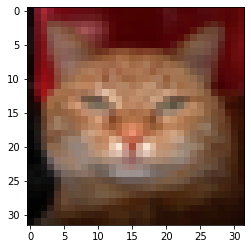

In [44]:
img = cats[0]

img_numpy = img.permute(1, 2, 0).contiguous().numpy()
img_numpy = img_numpy * (0.2023, 0.1994, 0.2010) + (0.4914, 0.4822, 0.4465)

plt.imshow(img_numpy)

In [45]:
embedding = variant.model(img[None, ...].cuda())

In [46]:
lookup = variant.model.word_lookup

l2_dist = ((lookup[:, :] - embedding) ** 2).sum(-1)
l2_dist

tensor([ 8.9501, 10.2926,  3.1692,  5.2816,  8.7077,  5.5293,  2.9581,  8.6583,
        10.7228,  9.5300], device='cuda:0', grad_fn=<SumBackward1>)

In [22]:
variant.class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [49]:
dog_l2_dist = ((lookup[:, :] - lookup[None, 5, :]) ** 2).sum(-1)
dog_l2_dist

tensor([14.8615, 14.7763, 10.2325,  4.3328, 14.4052,  0.0000, 12.5353,  9.6917,
        14.7291, 13.0752], device='cuda:0')

In [51]:
frog_l2_dist = ((lookup[:, :] - lookup[None, 6, :]) ** 2).sum(-1)
frog_l2_dist

tensor([15.7923, 17.3723,  8.2530, 10.3048, 15.7277, 12.5353,  0.0000, 14.6986,
        17.5691, 15.9819], device='cuda:0')

In [58]:
total = 0
closer = 0
for inputs_batch, labels_batch in variant.test_loader:
    for img, label in zip(inputs_batch, labels_batch):
        if variant.class_names[label] == 'cat':
            e = variant.model(img[None, ...].cuda())

            e_dist = ((lookup[:, :] - embedding) ** 2).sum(-1)

            c = e_dist.argmin().item()
            c_dist = ((lookup[:, :] - lookup[None, c, :]) ** 2).sum(-1)

            # if c != 5:
            if c_dist[3] < c_dist[5]:
                if e_dist[3] < e_dist[5]:
                    closer += 1
                total +=1
print(f'{closer/total*100:6.2f}%')

100.00%


In [59]:
total

1000